In [146]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue.core.sheet import Sheet

from tyssue import config
from tyssue.topology.sheet_topology import cell_division

from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.dynamics.sheet_vertex_model import SheetModel as model

from tyssue.core.generation import extrude
from tyssue.core.monolayer import Monolayer, MonolayerWithLamina
from tyssue.geometry.bulk_geometry import BulkGeometry, MonoLayerGeometry
from tyssue.dynamics.bulk_model import BulkModel, LaminaModel, set_model
from tyssue.solvers.sheet_vertex_solver import Solver

from tyssue.draw.vispy_draw import vp_view

from tyssue.draw.plt_draw import sheet_view

from tyssue.topology.sheet_topology import remove_face
from tyssue.core.objects import get_opposite
from tyssue.io.hdf5 import save_datasets, load_datasets

from tyssue.topology.sheet_topology import face_division, get_division_edges


In [158]:
datasets = load_datasets('small_ellipsoid.hf5',
                         data_names=['vert', 'edge',
                                     'face', 'cell'])
specs = config.geometry.bulk_spec()

monolayer = Monolayer('ell', datasets, specs)
monolayer.reset_index()
monolayer.reset_topo()


# ## Settings for the quasi-static model
# ### Apical layer
apical_spec = {
    'edge': {
        'line_tension': 0.12,},
    'face': {
        'contractility': 0.04,
        'prefered_area': 0.8,
        'area_elasticity': 1.0},
    'cell': {
        'prefered_vol': 1.0,
        'vol_elasticity': 1.0},
    'settings': {
        'grad_norm_factor': 1.0,
        'nrj_norm_factor': 1.0},}

# ### Modifier for each segment of the stratum
modifiers = {
    'sagittal': {
        'edge': {
            'line_tension': 0.1},
        'face': {
            'contractility': 0.05,
            'prefered_area': 0.2}
    },
    'basal': {
        'edge': {
            'line_tension': 0.5},
        'face': {
            'contractility': 0.1,
            'prefered_area': 0.2}},
    }

set_model(monolayer, BulkModel, apical_spec, modifiers)





In [159]:
monolayer.face_df = monolayer.face_df.dropna()

In [160]:
monolayer.reset_index()
monolayer.reset_topo()

In [161]:
res = Solver.find_energy_min(monolayer, BulkGeometry, BulkModel)

In [162]:
draw_specs = config.draw.sheet_spec()
canvas, view = vp_view(monolayer, **draw_specs)

In [163]:
mother = 8
mother_edges = monolayer.edge_df[
    monolayer.edge_df['cell'] == mother]
mother_faces = set(mother_edges['face'])

apical_face, = mother_edges[
    mother_edges['segment'] == 'apical']['face'].unique()
basal_face, = mother_edges[
    mother_edges['segment'] == 'basal']['face'].unique()




In [164]:
from tyssue.geometry.sheet_geometry import SheetGeometry

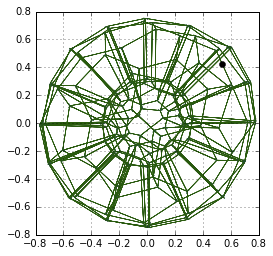

In [165]:
draw_specs = config.draw.sheet_spec()
draw_specs['vert']['visible'] = False
draw_specs['edge']['head_width'] = 0.01


fig, ax = sheet_view(monolayer, **draw_specs)

ax.plot(monolayer.face_df.loc[apical_face, 'x'],
        monolayer.face_df.loc[apical_face, 'y'], 'ko')

In [166]:
def basal_apical_axis(eptm, cell):
    """
    Returns a unit vector allong the apical-basal axis of the cell
    """
    edges = eptm.edge_df[eptm.edge_df['cell'] == cell]
    srce_segments = eptm.vert_df.loc[edges['srce'], 'segment']
    srce_segments.index = edges.index
    trgt_segments = eptm.vert_df.loc[edges['trgt'], 'segment']
    trgt_segments.index = edges.index
    ba_edges = edges[(srce_segments == 'apical') &
                     (trgt_segments == 'basal')]
    return ba_edges[eptm.dcoords].mean()

In [61]:
%pdb

Automatic pdb calling has been turned OFF


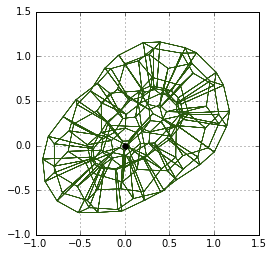

In [167]:
from tyssue.geometry.utils import rotation_matrix
ab_axis = basal_apical_axis(monolayer, mother)
n_xy = np.linalg.norm(ab_axis[['dx', 'dy']])
angle = -np.arctan2(n_xy, ab_axis.dz)
direction = [ab_axis.dy, -ab_axis.dx, 0]

rot = rotation_matrix(angle, direction)

#rot = SheetGeometry.face_rotation(monolayer, apical_face, np.pi/2)
for c in monolayer.coords:
    monolayer.vert_df[c] -= monolayer.cell_df.loc[mother, c]
monolayer.vert_df[monolayer.coords] = np.dot(monolayer.vert_df[monolayer.coords], rot)
BulkGeometry.update_all(monolayer)

draw_specs = config.draw.sheet_spec()
draw_specs['vert']['visible'] = False
draw_specs['edge']['head_width'] = 0.01


fig, ax = sheet_view(monolayer, **draw_specs)

ax.plot(monolayer.cell_df.loc[mother, 'x'],
        monolayer.cell_df.loc[mother, 'y'], 'ko')

In [168]:
basal_apical_axis(monolayer, mother)

dx    1.110223e-17
dy    4.996004e-17
dz    4.970846e-01
dtype: float64

In [169]:
draw_specs = config.draw.sheet_spec()
import matplotlib.pyplot as plt
colors = plt.cm.viridis(monolayer.edge_df['cell']/monolayer.edge_df['cell'].max())

draw_specs['edge']['color'] = colors

canvas, view = vp_view(monolayer, **draw_specs)

In [170]:
srce_x = monolayer.upcast_srce(monolayer.vert_df.x)
trgt_x = monolayer.upcast_trgt(monolayer.vert_df.x)

division_edges = mother_edges[((srce_x >= 0) &
                               (trgt_x <= 0))]

srce_pos = monolayer.vert_df.loc[division_edges['srce'],
                                 monolayer.coords].values
trgt_pos = monolayer.vert_df.loc[division_edges['trgt'],
                                 monolayer.coords].values
centers = (srce_pos + trgt_pos)/2
theta = np.arctan2(centers[:,2], centers[:, 1])

division_edges = division_edges.iloc[np.argsort(theta)]
division_edges

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,srce,trgt,face,segment,cell,nz,dy,dx,ny,nx,dz,sub_area,length,sub_vol,prefered_length,length_eleasticity,line_tension
edge,,,,,,,,,,,,,,,,,
28,2,64,5,apical,8,-0.028163,-0.043246,-0.138905,0.041296,0.039012,-0.255829,0.031704,0.294302,0.002580,0.0,0.0,0.120
676,6,16,127,sagittal,8,0.060300,0.081999,-0.258634,0.048418,-0.030398,-0.196222,0.041546,0.334841,0.001847,0.0,0.0,0.012
307,98,108,53,basal,8,0.001878,0.010538,-0.053982,-0.002219,-0.001821,-0.039895,0.001716,0.067946,0.000141,0.0,0.0,0.060
666,94,156,124,sagittal,8,0.000404,-0.013279,-0.032868,-0.017160,0.006230,-0.057187,0.009130,0.067283,0.000361,0.0,0.0,0.012


In [171]:
from tyssue.topology import base_topology, sheet_topology
import itertools

In [172]:

'''
a_edges = division_edges[division_edges['segment'] == 'apical'].index
b_edges = division_edges[division_edges['segment'] == 'basal'].index

vert_aa, new_aa, new_opp_aa = base_topology.add_vert(monolayer, a_edges[0])
vert_ab, new_ab, new_opp_ab = base_topology.add_vert(monolayer, a_edges[1])

vert_ba, new_ba, new_opp_ba = base_topology.add_vert(monolayer, b_edges[0])
vert_bb, new_bb, new_opp_bb = base_topology.add_vert(monolayer, b_edges[1])

vertices = [vert_aa, vert_ab, vert_ba, vert_bb]
'''
vertices = []
for edge in division_edges.index:
    new_vert, *new_edges = base_topology.add_vert(monolayer, edge)
    vertices.append(new_vert)


In [173]:
import itertools

pairs = set([frozenset([v1, v2]) for v1, v2
             in itertools.product(vertices,
                                  vertices)
             if v1 != v2])
daughter_faces = []
for v1, v2 in pairs:
    v1_edges = monolayer.edge_df[monolayer.edge_df['srce'] == v1]['face']
    v2_edges = monolayer.edge_df[monolayer.edge_df['srce'] == v2]['face']
    faces = set(v1_edges).intersection(v2_edges)
    for face in faces:
        daughter_faces.append(
            sheet_topology.face_division(monolayer, face, v1, v2))
BulkGeometry.update_all(monolayer)    

In [174]:
colors = plt.cm.viridis(monolayer.edge_df['cell']/monolayer.edge_df['cell'].max())
draw_specs['edge']['color'] = colors

canvas, view = vp_view(monolayer, **draw_specs)

In [175]:
daughter_faces


[372, 373, 374, 375, 376, 377]

In [176]:
face_cols = monolayer.face_df.iloc[-2:]

monolayer.face_df = monolayer.face_df.append(face_cols, ignore_index=True)
monolayer.face_df.index.name = 'face'

new_faces = monolayer.face_df.index[-2:]

num_new_edges = len(vertices)*2

edge_cols = monolayer.edge_df.iloc[-num_new_edges:]
monolayer.edge_df = monolayer.edge_df.append(edge_cols,
                                             ignore_index=True)
monolayer.edge_df.index.name = 'edge'
new_edges = monolayer.edge_df.index[-num_new_edges:]

cell_cols = monolayer.cell_df.loc[mother]
monolayer.cell_df = monolayer.cell_df.append(cell_cols,
                                             ignore_index=True)
monolayer.cell_df.index.name = 'cell'
new_cell = monolayer.cell_df.index[-1]


In [177]:
monolayer.face_df.loc[new_faces, 'segment'] = 'sagittal'
for v1, v2, edge, oppo in zip(vertices,
                              np.roll(vertices, -1),
                              new_edges[:4],
                              new_edges[4:]):
    monolayer.edge_df.loc[
        edge, ['srce', 'trgt', 'face', 'segment']] = v1, v2, new_faces[0], 'sagittal'
    monolayer.edge_df.loc[
        oppo, ['srce', 'trgt', 'face', 'segment']] = v2, v1, new_faces[1], 'sagittal'
    
    

In [178]:
monolayer.reset_index()
monolayer.reset_topo()


In [179]:
BulkGeometry.update_all(monolayer)

In [180]:
colors = plt.cm.viridis(monolayer.edge_df['cell']/monolayer.edge_df['cell'].max())
draw_specs['edge']['color'] = colors

canvas, view = vp_view(monolayer, **draw_specs)

In [181]:
f1_edges = monolayer.edge_df[
    monolayer.edge_df['face'] == new_faces[0]]
f2_edges = monolayer.edge_df[
    monolayer.edge_df['face'] == new_faces[1]]

monolayer.edge_df.loc[f1_edges.index, 'cell'] = mother
monolayer.edge_df.loc[f2_edges.index, 'cell'] = new_cell
m_septum = new_faces[0]


In [182]:
m_septum

378

In [183]:
mother_faces = monolayer.get_orbits('cell', 'face').loc[mother].unique()

m_septum_edges = monolayer.edge_df[monolayer.edge_df['face'] == m_septum]
m_septum_norm = m_septum_edges[monolayer.ncoords].mean()
m_septum_pos = monolayer.face_df.loc[m_septum, monolayer.coords]

for face in mother_faces:
    if face == m_septum:
        continue
    dr = monolayer.face_df.loc[face, monolayer.coords] - m_septum_pos
    proj = (dr.values * m_septum_norm).sum(axis=0)
    f_edges = monolayer.edge_df[monolayer.edge_df['face'] == face].index
    if proj < 0:
        monolayer.edge_df.loc[f_edges, 'cell'] = mother
    else:
        monolayer.edge_df.loc[f_edges, 'cell'] = new_cell


In [195]:
cell

64

In [194]:
ab_axis = MonoLayerGeometry.basal_apical_axis(monolayer, cell)
cell_edges = monolayer.edge_df[monolayer.edge_df["cell"] == cell].index
vert_pos_ = monolayer.vert_df.loc[set(cell_edges['srce'])]
vert_pos = vert_pos_.loc[vertices]
for c in monolayer.coords:
    vert_pos[c] -= monolayer.cell_df.loc[cell, c]


KeyError: False

In [184]:
res = Solver.find_energy_min(monolayer, BulkGeometry, BulkModel)
print(res['success'])
print(res['message'])


True
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [185]:

colors = plt.cm.viridis(monolayer.edge_df['cell']/monolayer.edge_df['cell'].max())
draw_specs['edge']['color'] = colors

canvas, view = vp_view(monolayer, **draw_specs)

In [37]:
%pdb

Automatic pdb calling has been turned ON
